# Ways to Detect and Remove the Outliers

While working on a Data Science project, what is it, that you look for? What is the most important part of the EDA phase? There are certain things which, if are not done in the EDA phase, can affect further statistical/Machine Learning modelling. One of them is finding “Outliers”. In this post we will try to understand what is an outlier? Why is it important to identify the outliers? What are the methods to outliers? Don’t worry, we won’t just go through the theory part but we will do some coding and plotting of the data too.

Credit: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

In [41]:
#Import the libraries
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_diabetes
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
sklearn.__version__

'1.6.1'

In [3]:
#Load the data
diabetes = load_diabetes()

#Find features and target
x = diabetes.data
y = diabetes.target

#Find the dic keys
print(diabetes.keys())

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])


In [4]:
#find features name
columns = diabetes.feature_names
columns

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [5]:
#Description of dataset
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [6]:
#Create dataframe
diabetes_df = pd.DataFrame(diabetes.data)
diabetes_df.columns = columns
diabetes_df.shape

(442, 10)

In [7]:
diabetes_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


<Axes: xlabel='s3'>

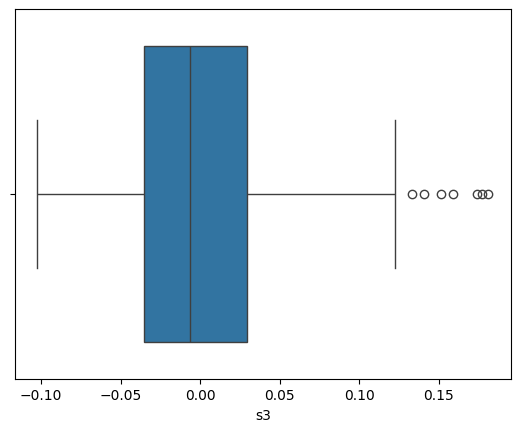

In [16]:
# Check1: Oulier detection - Univarite - Boxplot
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.boxplot(x=diabetes_df['s3'])

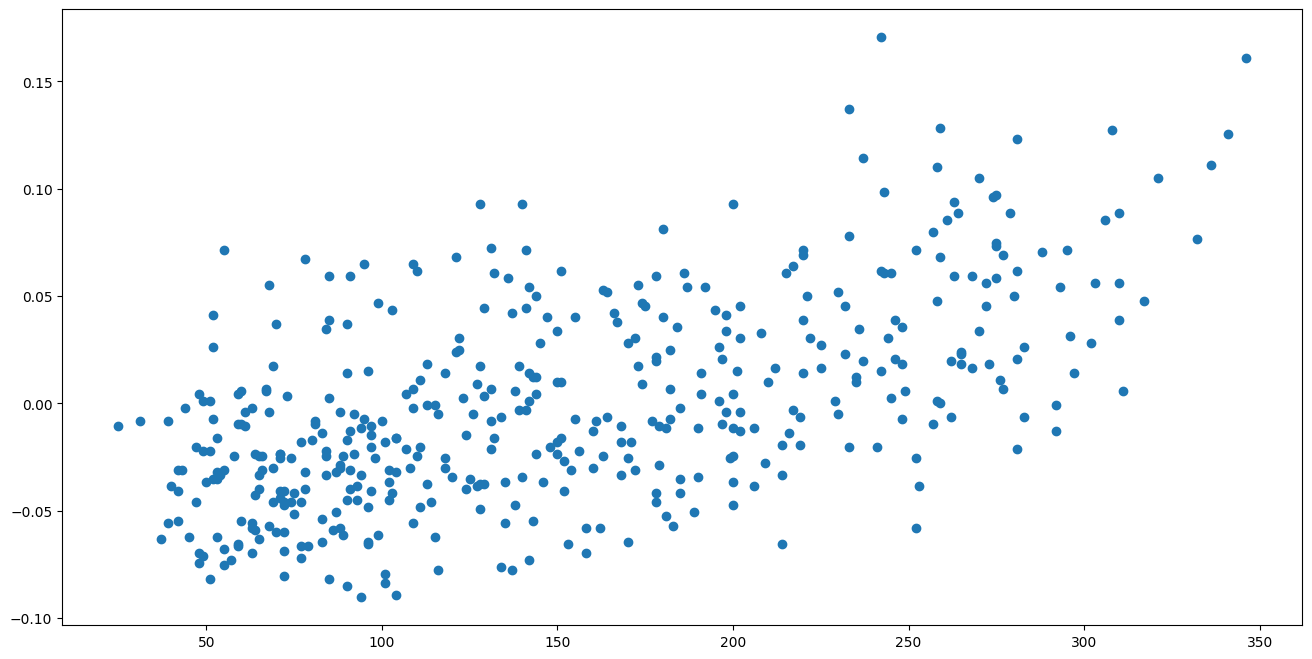

In [28]:
# Check2: Multivariate outlier analysis
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(diabetes.target, diabetes_df['bmi'])
plt.show()

In [31]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(diabetes_df))
z

array([[0.80050009, 1.06548848, 1.29708846, ..., 0.05449919, 0.41853093,
        0.37098854],
       [0.03956713, 0.93853666, 1.08218016, ..., 0.83030083, 1.43658851,
        1.93847913],
       [1.79330681, 1.06548848, 0.93453324, ..., 0.05449919, 0.06015558,
        0.54515416],
       ...,
       [0.87686984, 1.06548848, 0.33441002, ..., 0.23293356, 0.98564884,
        0.32567395],
       [0.9560041 , 0.93853666, 0.82123474, ..., 0.55838411, 0.93616291,
        0.54515416],
       [0.9560041 , 0.93853666, 1.53537419, ..., 0.83030083, 0.08875225,
        0.06442552]])

In [32]:
z.shape

(442, 10)

In [33]:
threshold = 3
print(np.where(z > 3)) # show row & columns

(array([ 58, 123, 123, 123, 216, 230, 230, 256, 260, 261, 269, 322, 336,
       367, 441]), array([6, 4, 5, 7, 7, 4, 5, 2, 6, 6, 6, 7, 7, 2, 6]))


## Removing "whole rows" with outliers


In [45]:
#diabetes_df_o = diabetes_df[(z <= 3).all(axis=1)]

class ZScoreOutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3.0):
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        z = stats.zscore(X, nan_policy='omit')
        mask = (np.abs(z) <= self.threshold).all(axis=1)
        return X[mask]

pipeline = Pipeline([
    ('remove_outliers', ZScoreOutlierRemover(threshold=3.0))
])

diabetes_df_o = pipeline.fit_transform(diabetes_df)

In [46]:
diabetes_df.shape

(442, 10)

In [47]:
diabetes_df_o.shape

(430, 10)

In [55]:
diabetes_df_o = diabetes_df

In [56]:
class IQRBasedOutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor

    def fit(self, X, y=None):
        # Compute Q1, Q3, and IQR during fit
        X = pd.DataFrame(X)
        self.Q1_ = X.quantile(0.25)
        self.Q3_ = X.quantile(0.75)
        self.IQR_ = self.Q3_ - self.Q1_
        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        lower_bound = self.Q1_ - self.factor * self.IQR_
        upper_bound = self.Q3_ + self.factor * self.IQR_
        mask = ~((X < lower_bound) | (X > upper_bound)).any(axis=1)
        return X[mask]

# Example usage
iqr_pipeline = Pipeline([
    ('remove_iqr_outliers', IQRBasedOutlierRemover(factor=1.5))
])

# Apply on diabetes_df_o (after Z-score filtering or standalone)
boston_df_out = iqr_pipeline.fit_transform(diabetes_df_o)

In [61]:
iqr_pipeline[0].IQR_

,0
age,0.075375
sex,0.095322
bmi,0.065477
bp,0.072300
s1,0.062606
s2,0.060203
s3,0.064429
s4,0.073802
s5,0.065678
s6,0.061096


In [62]:
boston_df_out.shape

(411, 10)